<a href="https://colab.research.google.com/github/hoon0624/garbage-classification-heroku/blob/master/Garbage_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# imports 
import numpy as np
from zipfile import ZipFile
import os
import glob
import matplotlib.pyplot as plt
from IPython.display import display, Image
import cv2
import random
import shutil
from pathlib import Path
import pandas as pd
from sklearn.metrics import confusion_matrix
from fastai.vision import *

In [5]:
# unzip files needed 
with ZipFile('garbage-classification.zip', 'r') as zipObj:
  zipObj.extractall()

# print file directory
for file in os.listdir("/content/Garbage classification/Garbage classification"):
  print(file)

trash
glass
cardboard
metal
paper
plastic


In [0]:
# organize data

# split indices as train, validation, and test with random sampling
def split_indices(folder, seed1, seed2):
  n = len(os.listdir(folder))
  total = list(range(1, n+1))

  random.seed(seed1)
  # 50/25/25 split 
  train = random.sample(list(range(1, n+1)), int (.5*n))
  
  remain = list(set(total) - set(train))

  random.seed(seed2)
  # valid has 25% of the data
  valid = random.sample(remain, int(.5*len(remain)))
  # test has the remaining data left (25% of the data)
  test = list(set(remain) - set(valid))

  return train, valid, test

# get list of file names of specific wate_type
def get_names(waste_type, indices):
  
  file_names = [waste_type + str(i) + ".jpg" for i in indices]
  return file_names

# move files into specific folder (test, valid, train)
def move_files(source_files, destination_folder):
  for file in source_files:
    shutil.move(file, destination_folder)

In [0]:
# organize data

# have individual folders for each category for train and valid 
subsets = ['train', 'valid']
waste_types = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

# create folders if they don't exist
for subset in subsets: 
  for waste_type in waste_types:
    folder = os.path.join('data', subset, waste_type)
    if not os.path.exists(folder):
      os.makedirs(folder)

# create folder for test
if not os.path.exists(os.path.join('data', 'test')):
  os.makedirs(os.path.join('data', 'test'))

for waste_type in waste_types:
  source_folder = os.path.join('Garbage classification/Garbage classification', waste_type)
  train_ind, valid_ind, test_ind = split_indices(source_folder, 1,1)

  # put data in the train folder according to each category
  train_names = get_names(waste_type, train_ind)
  train_source_files = [os.path.join(source_folder, name) for name in train_names]
  train_dest = "data/train/"+ waste_type
  move_files(train_source_files, train_dest)

  # put data in the valid folder according to each category
  valid_names = get_names(waste_type, valid_ind)
  valid_source_files = [os.path.join(source_folder, name) for name in valid_names]
  valid_dest = "data/valid/"+ waste_type
  move_files(valid_source_files, valid_dest)

  # put data in the test folder without categorizing
  test_names = get_names(waste_type, test_ind)
  test_source_files = [os.path.join(source_folder, name) for name in test_names]
  move_files(test_source_files, "data/test")

ImageDataBunch;

Train: LabelList (1262 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
trash,trash,trash,trash,trash
Path: /content/data;

Valid: LabelList (630 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
trash,trash,trash,trash,trash
Path: /content/data;

Test: LabelList (635 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: EmptyLabelList
,,,,
Path: /content/data
['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


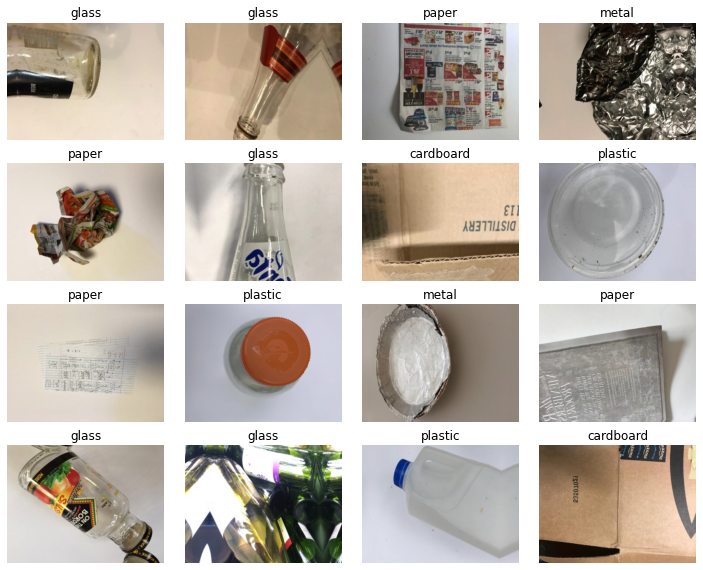

In [16]:
# data folder path
path = Path(os.getcwd())/"data"

tfms = get_transforms(do_flip=True, flip_vert=True)
data = ImageDataBunch.from_folder(path, test="test", ds_tfms=tfms, bs=16)

print(data)
print(data.classes)
data.show_batch(rows=4, figsize=(10,8))

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=[accuracy])

In [0]:
# find laerning rate
learn.lr_find(start_lr=1e-6, end_lr=1e1)
learn.recorder.plot(suggestion=True)

In [0]:
# train model
learn.fit_one_cycle(15, max_lr=1e-03)

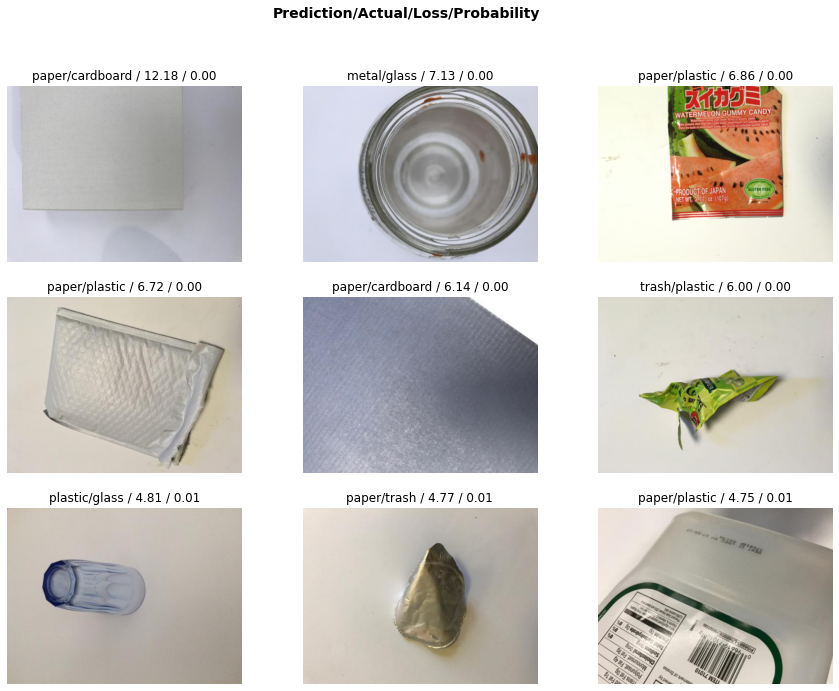

In [21]:
# top losses
interpret = ClassificationInterpretation.from_learner(learn)
losses, index = interpret.top_losses()
interpret.plot_top_losses(9, figsize=(15,11))

In [24]:
# most confused data
interpret.most_confused(min_val=2)

[('cardboard', 'paper', 6),
 ('metal', 'glass', 6),
 ('glass', 'metal', 5),
 ('plastic', 'glass', 5),
 ('plastic', 'metal', 5),
 ('plastic', 'paper', 5),
 ('glass', 'plastic', 4),
 ('paper', 'cardboard', 3),
 ('paper', 'trash', 3),
 ('plastic', 'trash', 3),
 ('trash', 'paper', 2)]

In [25]:
# predictions on test data set (y_test)
pred = learn.get_preds(ds_type= DatasetType.Test)

In [28]:
# y_test and y_pred
max_ind = np.asarray(np.argmax(pred[0], axis=1))

y_pred = []
for index in max_ind:
  y_pred.append(data.classes[index]) 
print(y_pred)

y = []
for label_path in data.test_ds.items:
  y.append(str(label_path))

pattern = re.compile("([a-z]+)[0-9]+")
for i in range(len(y)):
  y[i] = pattern.search(y[i]).group(1)

print(y)

['trash', 'glass', 'paper', 'paper', 'paper', 'glass', 'cardboard', 'metal', 'paper', 'glass', 'metal', 'plastic', 'cardboard', 'glass', 'glass', 'cardboard', 'glass', 'paper', 'metal', 'paper', 'metal', 'cardboard', 'paper', 'paper', 'plastic', 'paper', 'paper', 'glass', 'glass', 'paper', 'paper', 'glass', 'glass', 'paper', 'trash', 'cardboard', 'metal', 'plastic', 'glass', 'paper', 'cardboard', 'paper', 'trash', 'cardboard', 'cardboard', 'glass', 'paper', 'glass', 'cardboard', 'trash', 'cardboard', 'paper', 'metal', 'plastic', 'glass', 'plastic', 'cardboard', 'cardboard', 'glass', 'plastic', 'paper', 'metal', 'glass', 'paper', 'trash', 'paper', 'cardboard', 'plastic', 'glass', 'paper', 'paper', 'glass', 'trash', 'glass', 'glass', 'paper', 'metal', 'metal', 'paper', 'paper', 'glass', 'glass', 'trash', 'metal', 'metal', 'paper', 'cardboard', 'paper', 'glass', 'cardboard', 'metal', 'plastic', 'plastic', 'glass', 'paper', 'trash', 'paper', 'paper', 'glass', 'metal', 'glass', 'metal', 'me

In [29]:
# confusion matrix
conf_mat = confusion_matrix(y, y_pred)
print(conf_mat)

[[ 95   0   3   3   0   0]
 [  0 111   6   0   9   0]
 [  0  14  87   1   0   1]
 [  0   0   2 142   0   5]
 [  0   4   0   0 114   3]
 [  0   0   2   4   1  28]]


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Text(0.5, 15.0, 'predicted label')

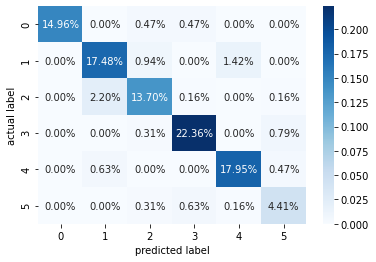

In [30]:
# visualize confusion matrix
import seaborn as sns

sns.heatmap(conf_mat/np.sum(conf_mat), annot=True, fmt='.2%', cmap='Blues')

plt.ylabel('actual label')
plt.xlabel('predicted label')

In [31]:
# test accuracy
correct = 0

for r in range(len(conf_mat)):
  for c in range(len(conf_mat)):
    if (r==c):
      correct += conf_mat[r,c]
    
accuracy = correct/sum(sum(conf_mat))
print(accuracy)

0.9086614173228347


In [0]:
# function that takes learn.get_preds and returns y_score (each probabilities)
def compute_yscore(data, pred):
  y_score = []
  for i in range(len(data.classes)):
    y_score.append(pred[0][:,i].numpy())
  
  return np.array(y_score)

              precision    recall  f1-score   support

   cardboard       1.00      0.94      0.97       101
       glass       0.86      0.88      0.87       126
       metal       0.87      0.84      0.86       103
       paper       0.95      0.95      0.95       149
     plastic       0.92      0.94      0.93       121
       trash       0.76      0.80      0.78        35

    accuracy                           0.91       635
   macro avg       0.89      0.89      0.89       635
weighted avg       0.91      0.91      0.91       635



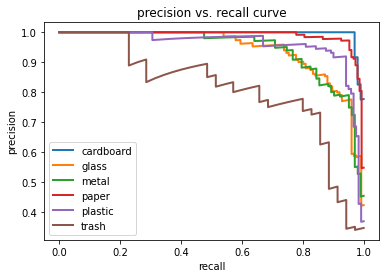

In [45]:
# precision and recall
from sklearn.metrics import classification_report
print(classification_report(y, y_pred))

# y_score
y_score = compute_yscore(data, pred)

# binarize y
from sklearn import preprocessing
from sklearn.metrics import recall_score
lb = preprocessing.LabelBinarizer()
lb.fit(y)
lb.classes_
y_bin = lb.transform(y)

# precision recall curve
from sklearn.metrics import precision_recall_curve
precision = dict()
recall = dict()
for i in range(len(data.classes)):
    precision[i], recall[i], _ = precision_recall_curve(y_bin[:,i],
                                                        y_score[i,:])
    plt.plot(recall[i], precision[i], lw=2, label=data.classes[i])

plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()

In [0]:
# save model as pkl file
learn.path = Path('drive/My Drive')
learn.export()

In [0]:
# save entire model as pth file
learn.model_dir='.'
learn.save('model_9086', return_path=True)

In [19]:
# load model in pth file
learn = cnn_learner(data, models.resnet34, metrics=[accuracy])
learn.load('/content/drive/My Drive/model_9086')

learn.summary()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 192, 256]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 192, 256]       128        True      
______________________________________________________________________
ReLU                 [64, 192, 256]       0          False     
______________________________________________________________________
MaxPool2d            [64, 96, 128]        0          False     
______________________________________________________________________
Conv2d               [64, 96, 128]        36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 96, 128]        128        True      
______________________________________________________________________
ReLU                 [64, 96, 128]        0          False     
___________________________________________________

In [0]:
# load model in pkl file
learn2 = load_learner(path='/content/drive/My Drive', file='export.pkl')
classes = learn.data.classes